In [1]:
%matplotlib inline
from sys import path
from os.path import join as joinpath
from os.path import normpath
path.append(joinpath("..", "src"))

from aminoacid import AminoAcid
from dssp import DSSP
from structure import GOR3

# Secondary structure prediction

Proteins have four levels of structure:
* The **primary** structure is the sequence of amino acids that makes up the protein.
* The **secondary** structure refers to particular shapes that sub-sequences of the protein tend to form, due to *hydrogen bonds*. The most common among these are *alpha helices* and *beta sheets*.
* The **tertiary** structure is how the whole protein is "folded" (i.e. its 3D structure). The folding is due to hydrophobic interactions, and stops when the shape is stabilized by other interactions.
* The **quartenary** structure is particular to *multimers*, proteins that are made up of multiple subunits.  It describes how these subunits are arranged together.

The goal of this project is to predict the secondary structure of a protein, based on its primary structure. This is useful in the context of multiple sequence alignment, since proteins that exerce the same function are likely to have similar secondary structure as well as related primary structures. Fortunately for us, secondary structures can be observed experimentally via multiple techniques, granting us the possibility to train and verify our prediction system with real-world data. Furthermore, the folding of proteins (into their secondary and tertiary stable structures) is highly deterministic, which means it can be predicted based on the primary structure alone.

## DSSP definition

DSSP stands for *Define Secondary Structure of Proteins* and is a standard for how the atomic 3D arrangement of a protein is translated into secondary structures. DSSP admits eight types of secondary structures and assigns one to each amino acid from a protein by examining their spacial coordinates. We won't be implementing DSSP, however we will need to parse `.dssp` files in order to extract secondary structure information to train and verify our prediction system. Here is a class that parses such files:

Note that we won't be using all eight structures, but rather regroup them into four classes:
* **Helix** (H) regroups 3,4 and 5-turn helixes
* **Sheet** (E) regroups parallel/antiparallel $\beta$-sheets and isolated $\beta$-bridges
* **Turn** (T) is the hydrogen bonded turn
* **Coil** (C) regroups coils (no structure) and bends


## GOR prediction

GOR stands for *Garnier-Osguthorpe-Robson* and is a secondary structure prediction method based on information theory. It has had several releases, each increasing the prediction accuracy, but we will only focus on the GOR III version here. This version uses two kinds of information to issue a prediction, all based on known protein-structure pairs parsed from a *training dataset*. In the following formulas, $R_j$ is the residue (amino acid) at index $j$ whose structure is being predicted, $S_j$ is one of the structures, $n-S_j$ represents all of the structures except for $S_j$, $f_{c_1,...c_k}$ is the frequency with which all conditions $c_1$ through $c_k$ are met within the training dataset and $I(\Delta S, ...) = I(S, ...) - I(n-S, ...)$ is the information difference between the predictions concerning $S$ and $n-S$.
* **Individual** information concerns only the amino acid at position $j$: $$I(\Delta S_j, R_j) = \log{\left( \frac{f_{S_j,R_j}}{f_{n-S_j,R_j}} \right)} + \log{\left( \frac{f_{n-S_j}}{f_{S_j}} \right)}$$
* **Directional** information was introduced in version 2 and concerns the amino acids surrounding position $j$, from $j-n$ to $j+n$: $$I(\Delta S_j, R_{j+m}) = \log{\left( \frac{f_{S_j,R_{j+m}}}{f_{n-S_j,R_{j+m}}} \right)} + \log{\left( \frac{f_{n-S_j}}{f_{S_j}} \right)}$$
* **Pair-wise** information has replaced directional information since version 3 and concerns the pairs $(R_j, R_{j+m}) \forall m \in [-n, -1] \cup [1, n]$: $$I(\Delta S_j, R_{j+m} | R_j) = \log{\left( \frac{f_{S_j,R_{j+m},R_j}}{f_{n-S_j,R_{j+m},R_j}} \right)} + \log{\left( \frac{f_{n-S},R_j}{f_{S},R_j} \right)}$$

Overall, the formula applied for the GOR III prediction is: $$I(\Delta S_j, R_{j-n} ... R_{j+n}) = I(\Delta S_j, R_j) + \sum_{m=-n, m \neq 0}^{m=n}{I(\Delta S_j, R_{j+m} | R_j)}$$

Here is an implementation of the algorithm, that we can train with new sequences then use to predict the structure of other sequences:

## Prediction quality
Our model can be seen as a set of binary classifiers, each predicting if a given amino acid belongs or not to one structure. There is one classifier per structure, each has its own values for $TP$ (true positives), $TN$ (true negatives), $FP$ (false positives) and $FN$ (false negatives).

### Q3
$Q_3$ is equal to the number of correctly predicted residues, divided by the total number of residues. In our case, since we know of four different structures, anything over $\frac{1}{4} = 0.25$ is better than completely random predictions.

### MCC
*Matthews Correlation Coefficient* (MCC)
$$\frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

### ROC Curve
*Receiver Operating Characteristic* (ROC) curve is a graphical representation of a binary classifier's results. The curve is obtained by plotting together the true positive rate or TPR along the $y$ axis, and the false positive rate or FPR along the $x$ axis. The data is generated for different threshold values which discriminate the positive and negative results. The curve is usually displayed along with a diagonal line joining the dots $(0,0)$ and $(1,1)$, representing the random classifier's ROC (which has a 50% chance of classifying an instance as positive or negative). If our classifier's curve is on top of that line, it means it performs better. Furthermore, the point from our curve closest to $(0,1)$ has the best threshold for efficiently classifying data.

### AUC
*Area Under Curve* (AUC) is the area under a curve. The AUC of a ROC Curve is equal to the probability that its binary classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

## Results

Time to run that bytecode.

### Parsing DSSP files

The first step towards predicting structures is to gather training and validation data. Fortunately, our dear TA has provided us with all the `.dssp` files we need. The only miscellaneous stuff here is that we're not interested in the whole data, just some chains from some files (specified in `info` files). The output goes in the `PARSED` files in a format similar to `fasta`, where the structure follows the sequence.

In [2]:
datasetPath = joinpath("..", "resources", "dataset")
with open(joinpath(datasetPath, "CATH_info.txt")) as infoFile:
	with open(joinpath(datasetPath, "CATH_info-PARSED.txt"), 'w') as outFile:
		dsspPath = joinpath(datasetPath, "dssp", "")
		for line in infoFile.readlines():
			d = DSSP(dsspPath + line[0:4] + ".dssp")
			description = "> " + d.identifier + "|" + d.protein + "|" + d.organism
			seq, struct = d.getSequenceStructure(line[4])
			
			outFile.writelines(l + "\n" for l in [description,seq,struct])
		
with open(joinpath(datasetPath, "CATH_info_test.txt")) as infoFile:
	with open(joinpath(datasetPath, "CATH_info_test-PARSED.txt"), 'w') as outFile:
		dsspTestPath = joinpath(datasetPath, "dssp_test", "")
		for line in infoFile.readlines():
			d = DSSP(dsspTestPath + line[0:4] + ".dssp")
			description = "> " + d.identifier + "|" + d.protein + "|" + d.organism
			seq, struct = d.getSequenceStructure(line[4])
			
			outFile.writelines(l + "\n" for l in [description,seq,struct])

### Training GOR III

We can now create our `GOR3` instance and train it with the extracted training data:

In [3]:
gor3Pred = GOR3()

with open(joinpath(datasetPath, "CATH_info-PARSED.txt")) as inFile:
	index = 0
	sequence = ""
	for line in inFile.readlines():
		line = line.strip().upper()
		if not (line=="" or line[0]==">"):
			#Line is a sequence
			if index % 2 == 0:
				sequence = line
			#Line is a structure
			else:
				gor3Pred.train(sequence, line)
			index += 1

### Predicting structures

Now that it's trained, our object can be used to issue structure predictions. Here are the results for the sequences from the validation data (real structure on top, predicted structure at the bottom):

In [4]:
with open(joinpath(datasetPath, "CATH_info_test-PARSED.txt")) as inFile:
	index = 0
	sequence = ""
	for line in inFile.readlines():
		line = line.strip().upper()
		if not (line=="" or line[0]==">"):
			#Line is a sequence
			if index % 2 == 0:
				sequence = line
			#Line is a structure
			else:
				structure = line
				prediction = gor3Pred.predict(sequence, structure)
				inter = "".join([":" if s1==s2 else " " for s1,s2 in zip(structure, prediction)])
				
				print("-------- STRUCTURE (top) vs PREDICTION (bottom) --------")
				print("True Positive Rate:", round(inter.count(":")/len(inter), 2))
				print()
				chunk = 80
				for start in range(0, len(structure), chunk):
					stop = start+chunk+1 if start+chunk+1<=len(structure) else len(structure)
					print(structure[start:stop])
					print(inter[start:stop])
					print(prediction[start:stop])
					print()
				print()
				
			index += 1

-------- STRUCTURE (top) vs PREDICTION (bottom) --------
True Positive Rate: 0.31

CCCTTTCCTTCCCCHHHHHHHHHHHHHHCTTTEEEEEEEECTTCCEEEEEEECCCCCCCCEEEEEECCCTTCHHHHHHHHH
    :            :::::::::::         : :      ::::::        :::: :   :     ::: ::
ETTETEETEEEEETETTHHHHHHHHHHHHHHHHHHHHETEEEHTETEEEEEETETTTTETEEEETETEHTETEEEHHHTHH

HHHHHHHHHTTTCHHHHHHHHHCEEEEECCCCHHHHHHHHHTCTTCCCCCCCCCCCCCCCCCHHHCCCCCTTCCCCECCTT
:  :      ::       : :  :::   :            :                           :       : 
HEEHTEETTETTTTTECEEHTHHTEEETEECTTTTEEECTTHTTHEETEHTEEETTEEETETETTTETHTETTETETTTTE

TCTTECCCCTTCCHHHHHHHHHHHHHCCEEEEEEEEECCCEEEECCCCCCCCCTTHHHHHHHHHHHHHHHHHHHCCCCEEE
  : :     :                 : :::       ::::         ::: :: ::::::::::::      :: 
ETTEEETHEETEEEEETTEETEETTETTETEEEHHHHHTTEEEETETEEEETETTHEHHTHHHHHHHHHHHHEETETEEET

EEHHHHCCCCCCCHHHHHHHTTCCEEEEEEECCCCCCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHC
 :         :         :  ::::: :  :        :::::  ::::::  :         
TEEEEEEEEEECTEETEEETETETEEEEETETTCTTHTEE

### Checking prediction quality

Here are the quality measures for our predictions, as explained in the "Prediction quality" section:

----- Overall quality -----
Q3: 0.37
MCC: 0.16

----- Receiver Operating Characteristic Curve -----
Classifier: H
AUC: 0.753714094019


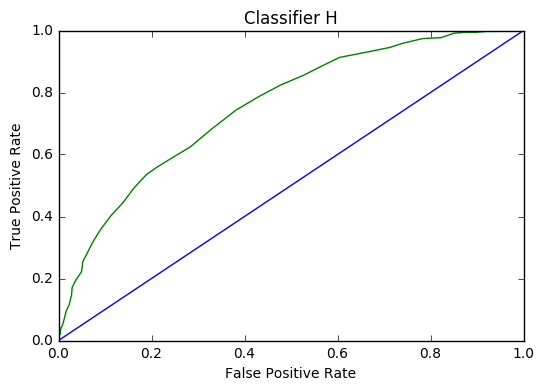

----- Receiver Operating Characteristic Curve -----
Classifier: E
AUC: 0.689504879289


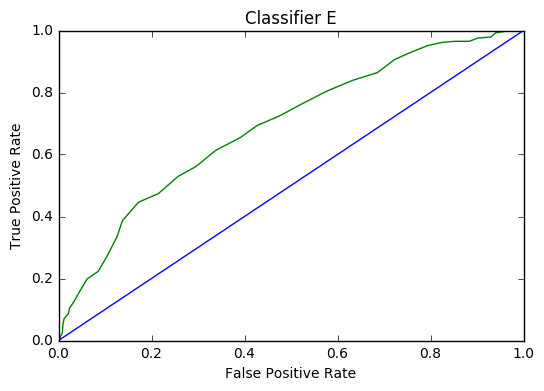

----- Receiver Operating Characteristic Curve -----
Classifier: T
AUC: 0.636629269112


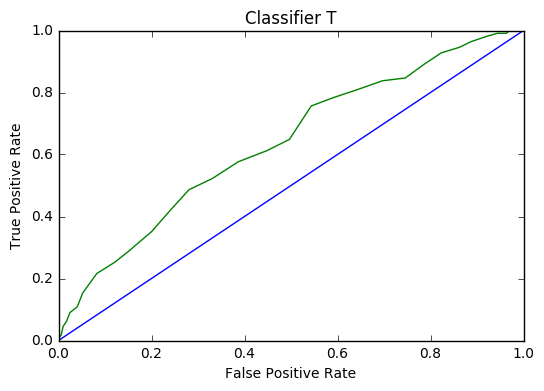

----- Receiver Operating Characteristic Curve -----
Classifier: C
AUC: 0.667159382138


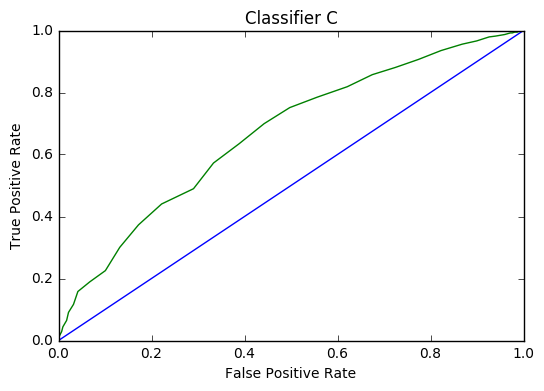

In [5]:
q3, mcc = gor3Pred.getQuality()
print("----- Overall quality -----")
print("Q3:", round(q3, 2))
print("MCC:", round(mcc, 2))
print()
gor3Pred.plotROC()

As shown by the AUC and the ROC curves, our classifiers are definitely better than completely random: the overall Q3 of 0.37 bests the random Q3 (0.25). However they do not perform very well when compared to other experimental results (Garnier et al, 1996) where the GOR 3 algorithm was trained with a database of 267 proteins, which obtained a Q3 of around 63.3% (yet this may be overestimated by 1% due to overfitting the training data by choosing better pseudocounts). In fact our Q3 is even worse than that of a random classifier with a distribution matching the real-world frequency of the structures, which is around 0.38.

In conclusion, I wouldn't use this classifier for anything too serious. However the implementation of the GOR 3 algorithm should be complete, therefore with a better training set we may be able to achieve similar results to other experiments.